## Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import tensorflow as tf
import os

In [2]:
!git clone https://github.com/taslimamindia/ProjectResNet.git

Cloning into 'ProjectResNet'...
remote: Enumerating objects: 48430, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 48430 (delta 4), reused 12 (delta 2), pack-reused 48415
Receiving objects: 100% (48430/48430), 47.02 MiB | 25.34 MiB/s, done.
Resolving deltas: 100% (1226/1226), done.
Checking out files: 100% (54056/54056), done.


In [3]:
!ls

ProjectResNet  sample_data


#### Data loading

In [19]:
path = "ProjectResNet/" #Github
# path = "" #Local
labels = pd.read_csv(path + "ArSL_Data_Labels.csv")
labels = labels.drop(columns="#")
new_labels = [(labels["Class"][item], labels["File_Name"][item]) for item in labels.index]
images = [cv.imread(path + "ArASL_Database_54K_Final/"+cl+"/"+f) for cl, f in new_labels]

KeyboardInterrupt: 

#### Numbers of images

In [3]:
print("numbers of images is ", len(images), labels.shape)

numbers of images is  54049 (54049, 2)


#### Some useful functions

In [4]:
def dico_size(shapes):
    dico = {}
    for shape in shapes:
        if dico.get(shape, False) == False:
            dico[shape] = 1
        else: 
            dico[shape] = dico[shape] + 1
    return dico

#### Visualize images sizes in our dataset

In [5]:
shapes = [img.shape for img in images]
shapes_sorted = sorted(shapes)
dico_size(shapes_sorted)

{(64, 64, 3): 53401, (256, 256, 3): 638, (1024, 768, 3): 10}

#### Resize all images to (64x64x3)

In [6]:
images_resized = []
for img in images:
    if img.shape != (64, 64, 3):
        img = cv.resize(img, (64, 64), interpolation = cv.INTER_AREA)
    images_resized.append(img)

In [7]:
dico_size(sorted([img.shape for img in images_resized]))

{(64, 64, 3): 54049}

In [8]:
data = np.array(images_resized)
print(data.shape)

(54049, 64, 64, 3)


In [9]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
y = labels
# # Encode labels in column 'species'.
y['Class'] = label_encoder.fit_transform(y['Class'])
uniq_labels=y["Class"].unique()
y = y['Class'].to_numpy()
y.shape


(54049,)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2)
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("x_train", X_train.shape, "y_train", y_train.shape, "\nx_test", X_test.shape, "y_test", y_test.shape)

x_train (43239, 64, 64, 3) y_train (43239, 32) 
x_test (10810, 64, 64, 3) y_test (10810, 32)


In [13]:
#Initialising ResNet50
classifier_resnet = ResNet50(input_shape= (64, 64, 3),include_top=False,weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [14]:
classifier = classifier_resnet.output#head mode
classifier = Flatten()(classifier)#adding layer of flatten
classifier = Dropout(0.6)(classifier)
classifier = Dense(units=32, activation='softmax')(classifier)

model = Model(inputs = classifier_resnet.input , outputs = classifier)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Notre architecture

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

#### Entrainement du modèle

In [16]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64,validation_data=(X_test,y_test))

Epoch 1/15
676/676 [==============================] - 76s 90ms/step - loss: 1.5733 - accuracy: 0.6737 - val_loss: 3.2163 - val_accuracy: 0.1029
Epoch 2/15
676/676 [==============================] - 59s 87ms/step - loss: 0.6512 - accuracy: 0.8555 - val_loss: 0.9255 - val_accuracy: 0.7704
Epoch 3/15
676/676 [==============================] - 59s 87ms/step - loss: 0.4563 - accuracy: 0.8959 - val_loss: 0.1872 - val_accuracy: 0.9493
Epoch 4/15
676/676 [==============================] - 60s 89ms/step - loss: 0.1483 - accuracy: 0.9621 - val_loss: 4.3089 - val_accuracy: 0.3793
Epoch 5/15
676/676 [==============================] - 59s 87ms/step - loss: 0.5116 - accuracy: 0.8959 - val_loss: 9.8105 - val_accuracy: 0.2404
Epoch 6/15
676/676 [==============================] - 59s 87ms/step - loss: 0.2816 - accuracy: 0.9379 - val_loss: 0.6394 - val_accuracy: 0.8470
Epoch 7/15
676/676 [==============================] - 59s 87ms/step - loss: 0.1497 - accuracy: 0.9647 - val_loss: 0.0957 - val_accuracy:

#### Le score de notre modèle

In [12]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 99.075 %


#### La matrice de confusion

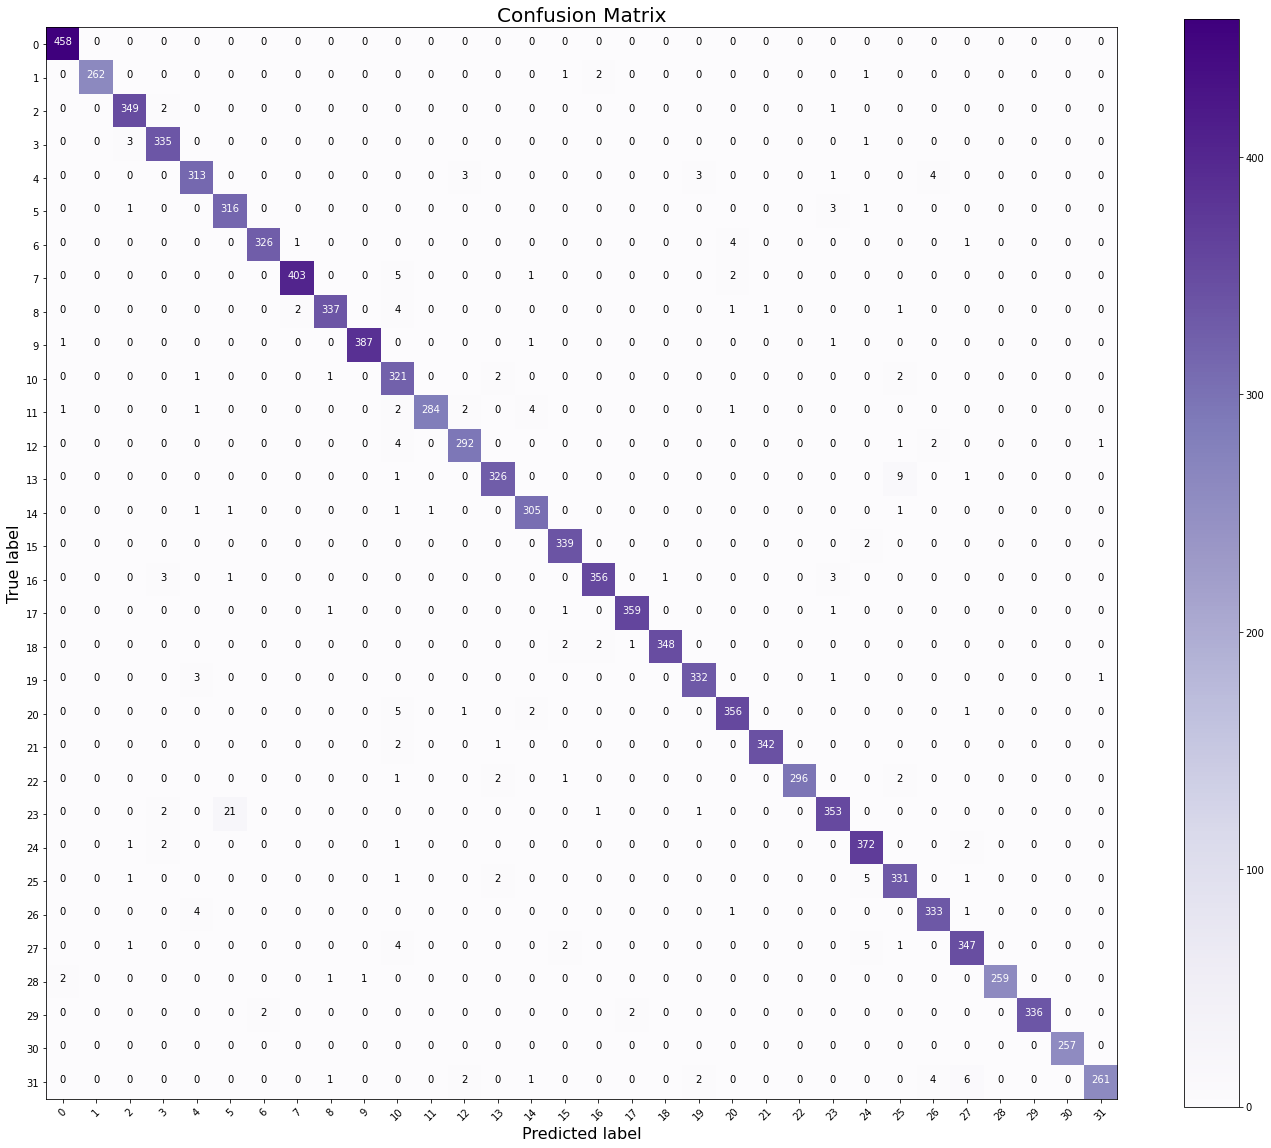

In [21]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

#### resnet50 accuracy and loss plot

In [17]:
history = model

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of ResNet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

TypeError: 'History' object is not subscriptable